# Estimating Yearly Revenues

#### Daniele Marmiroli, February 17th, 2018


## Overview

The aim of the present document is to produce a predictive model of yearly corporate revenues with particular focus on 2017 reports from Amazon. We will use datasets including roughly 500 corporate balance sheets entries from 11 different industry sectors for the years 2012-2016. We study  correlations and perform principal components analysis in order to isolate optimal sets of predictors in the following three cases: all available data, Amazon industry sector only, Amazon industry subsector only. We deploy predictions in the three cases using linear regression and comment on the results. Our best result falls short of the observed datum by roughly 5%, though it must be said that the time span narrowness of the dataset implies that the model is, broadly speeking, untrustworthy. In particular, the strong linear retarded correlation observed is possibly just a consequence of the fact that the entire market (see e.g. SP500 or tech subindex) grew monotonically within the same period of time. 


## Dataset

We start with a basic analysis of the dataset cleaning missing data points and NaN's and eventually purging fields. The dataset is somewhat small, which doesn't leave much space to experimenting models beyond the linear approximation, thus the choice of reling on linear regression.

We must comment on the decision not to use price quotes. Market positioning about corporate shares is mostly related to investing opportunities, meaning medium term appreciation and dividends. Both are related to more itricate parameters like the EBITDA, which require thorough knowledge of corporate balace sheets and precise estimates of revenues/liabilities that come from financial activities etc. As we will see in the following the correlation between revenues and EBIT (EBITDA is not reported) doesn't justify adding price quotes as an explicative variable.

Let's start with an overall inspection. First locate the fields realtive to our target:

In [8]:
# first things first ...
import datetime
from os import rename, mkdir, listdir
from os.path import splitext, exists
from calendar import month_name
from urllib.request import urlretrieve
from zipfile import ZipFile
import csv
import numpy as np
import pandas as pd
import pickle as pk
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score


# load data, basic clean, pickle
filename1 = 'fundamentals.csv'
Fundamentals = pd.read_csv(filename1)
    
filename2 = 'securities.csv'
Securities = pd.read_csv(filename2)

print('Descriptive fields available:\n')
print(Securities.columns)
print('\n\nQuantitative fields available:\n')
print(Fundamentals.columns)

Descriptive fields available:

Index(['Ticker symbol', 'Security', 'SEC filings', 'GICS Sector',
       'GICS Sub Industry', 'Address of Headquarters', 'Date first added',
       'CIK'],
      dtype='object')


Quantitative fields available:

Index(['Unnamed: 0', 'Ticker Symbol', 'Period Ending', 'Accounts Payable',
       'Accounts Receivable', 'Add'l income/expense items', 'After Tax ROE',
       'Capital Expenditures', 'Capital Surplus', 'Cash Ratio',
       'Cash and Cash Equivalents', 'Changes in Inventories', 'Common Stocks',
       'Cost of Revenue', 'Current Ratio', 'Deferred Asset Charges',
       'Deferred Liability Charges', 'Depreciation',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Effect of Exchange Rate',
       'Equity Earnings/Loss Unconsolidated Subsidiary', 'Fixed Assets',
       'Goodwill', 'Gross Margin', 'Gross Profit', 'Income Tax',
       'Intangible Assets', 'Interest Expense', 'Inventory', 'Investments',
       'Liabilities', 'Lon

We are interested in 'Ticker symbol' = 'AMZN' and relative market sector. Also interesting is to have an overview of population by sector. 

In [164]:
Securities[Securities['Ticker symbol']=='AMZN']

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
26,AMZN,Amazon.com Inc,reports,Consumer Discretionary,Internet & Direct Marketing Retail,"Seattle, Washington",2005-11-18,1018724


In [293]:
Securities['GICS Sector'].value_counts()

Consumer Discretionary         85
Industrials                    69
Information Technology         68
Financials                     64
Health Care                    59
Consumer Staples               37
Energy                         36
Real Estate                    29
Utilities                      28
Materials                      25
Telecommunications Services     5
Name: GICS Sector, dtype: int64

We can isolate the two subsets 'GICS Sector' and 'GICS Sub Industry' relevant for our analysis. Let's first double check which securities appear in the 'Fundamentals' table and drop items we have no data about, then compile these two lists. Also, we drop securities having less than 4 yearly observations (and thus less than 2 yearly % changes computable). Amazon appears to be in the most polpulated GICS Sector which surely make for better staistics. On the other hand this classification is somewhat obsolete given Amazon's own recent shift towards computational services, which is adding up an increasing slice of their profits.

In [201]:
for i,sec in enumerate(Securities['Ticker symbol']):
    found = Fundamentals['Ticker Symbol']==sec
    if len(Fundamentals[found]) > 0 & len(Fundamentals[found]) < 3:
        Fundamentals.drop(Fundamentals[found].index)
        Securities.drop(labels=i)
    elif len(Fundamentals[found]) == 0:
        Securities.drop(labels=i)


print('All Securities: ' + str(len(Securities)))
SecInSector = Securities[Securities['GICS Sector']=='Consumer Discretionary']
print('Securities in same industry sector: ' +str(len(SecInSector)))
SecInSubSector = Securities[Securities['GICS Sub Industry']=='Internet & Direct Marketing Retail']
print('Securities in same sub sector: ' +str(len(SecInSubSector)))

All Securities: 505
Securities in same industry sector: 85
Securities in same sub sector: 4


### Purge excessively sparse fields

Let's count missing data points in the three cases above. There might be big differences in how data are reported and availability thereof will condition our model choice. Below I set a 'Threshold' in percentage terms (10% here), and drop all columns whose missing data counts exceed it. I repeat the procedure for sector and sub-sector data and give a useful graphic representation of missing-% for each field.

Dropping the following 31 columns in AllData:

Total Current Assets
Deferred Asset Charges
Current Ratio
Long-Term Investments
Cash Ratio
Other Current Assets
Effect of Exchange Rate
Total Current Liabilities
Other Current Liabilities
Short-Term Investments
Changes in Inventories
Non-Recurring Items
Goodwill
Investments
Short-Term Debt / Current Portion of Long-Term Debt
Capital Surplus
Other Operating Items
Equity Earnings/Loss Unconsolidated Subsidiary
Intangible Assets
Research and Development
Add'l income/expense items
Other Financing Activities
Deferred Liability Charges
Earnings Per Share
Misc. Stocks
Quick Ratio
Minority Interest
Treasury Stock
Inventory
Interest Expense
Estimated Shares Outstanding


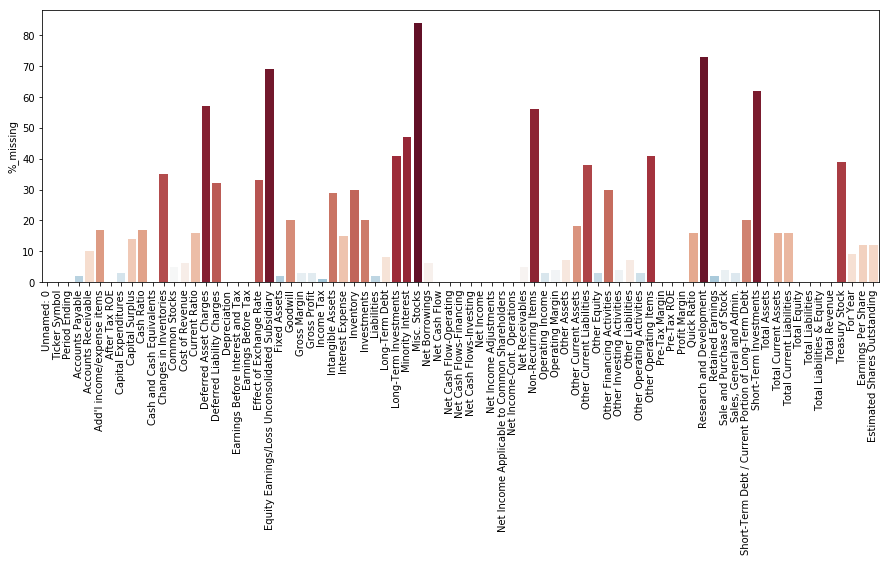

In [202]:
AllData = Fundamentals
Threshold = 10;
Missing = pd.DataFrame(index=['type', 'num_missing', '%_missing'])
L  = len(AllData)
for i,c in enumerate(AllData.columns):
    if AllData[c].dtypes == 'float64':
        n = len(AllData[AllData[c]==0]) + len(AllData[AllData[c].isna()])
        t = 'numeric'
    else:
        n = len(AllData[AllData[c].isnull()]) + len(AllData[AllData[c].isna()])
        t = 'text'
    
    p = int(n/L*100)
    Missing.insert(loc=len(Missing.columns), column=c, value=[t, n, p])
        
        
fig,axn = plt.subplots(figsize=(15,5)) 
pal = sns.color_palette("RdBu", len(Missing.columns))
Vals = Missing.loc['%_missing']
rank = Vals.argsort().argsort()
g = sns.barplot(ax=axn, x=Missing.columns, y=Vals, palette=np.array(pal[::-1])[rank])
g.set_xticklabels(labels=Missing.columns, rotation=90);

ColsToDrop = Missing.columns[Missing.loc['%_missing']>Threshold]

print('Dropping the following ' + str(len(ColsToDrop)) + ' columns in AllData:\n')
for row in set(ColsToDrop): print(row)
#Missing = Missing.drop(columns=ColsToDrop)
AllData = AllData.drop(columns=ColsToDrop)

Dropping the following 26 columns in SectorData:

Deferred Asset Charges
Long-Term Investments
Effect of Exchange Rate
Other Current Liabilities
Short-Term Investments
Changes in Inventories
Non-Recurring Items
Goodwill
Investments
Short-Term Debt / Current Portion of Long-Term Debt
Accounts Receivable
Other Operating Items
Equity Earnings/Loss Unconsolidated Subsidiary
Intangible Assets
Research and Development
Add'l income/expense items
For Year
Other Financing Activities
Deferred Liability Charges
Earnings Per Share
Misc. Stocks
Estimated Shares Outstanding
Minority Interest
Treasury Stock
Inventory
Interest Expense


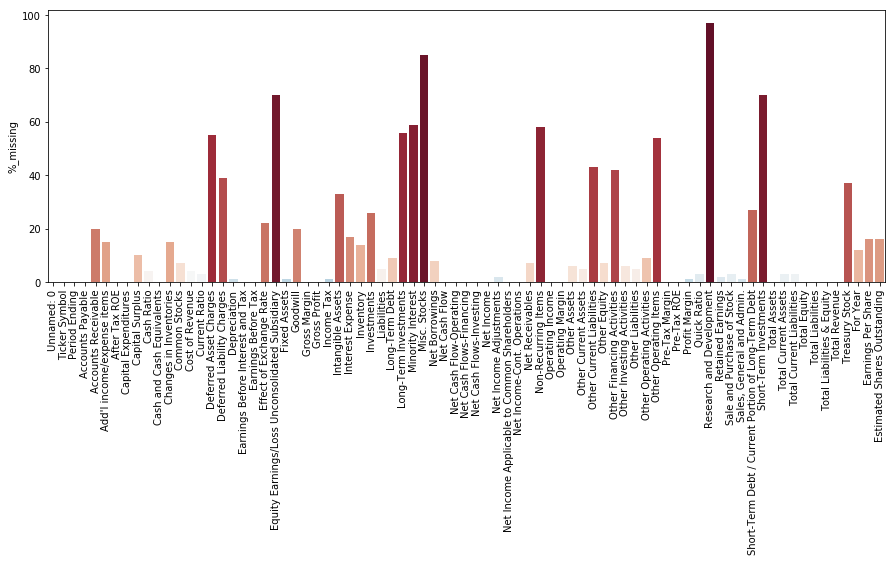

In [213]:
SectorData = pd.DataFrame(columns=Fundamentals.columns)
for sec in SecInSector['Ticker symbol']:
    SectorData = pd.concat([ SectorData, Fundamentals[Fundamentals['Ticker Symbol']==sec] ])

Threshold = 10;
Missing = pd.DataFrame(index=['type', 'num_missing', '%_missing'])
L  = len(SectorData)
for i,c in enumerate(SectorData.columns):
    if SectorData[c].dtypes == 'float64':
        n = len(SectorData[SectorData[c]==0]) + len(SectorData[SectorData[c].isna()])
        t = 'numeric'
    else:
        n = len(SectorData[SectorData[c].isnull()]) + len(SectorData[SectorData[c].isna()])
        t = 'text'
    
    p = int(n/L*100)
    Missing.insert(loc=len(Missing.columns), column=c, value=[t, n, p])
        
        
fig,axn = plt.subplots(figsize=(15,5)) 
pal = sns.color_palette("RdBu", len(Missing.columns))
Vals = Missing.loc['%_missing']
rank = Vals.argsort().argsort()
g = sns.barplot(ax=axn, x=Missing.columns, y=Vals, palette=np.array(pal[::-1])[rank])
g.set_xticklabels(labels=Missing.columns, rotation=90);

ColsToDrop = Missing.columns[Missing.loc['%_missing']>Threshold]

print('Dropping the following ' + str(len(ColsToDrop)) + ' columns in SectorData:\n')
for row in set(ColsToDrop): print(row)
#Missing = Missing.drop(columns=ColsToDrop)
SectorData = SectorData.drop(columns=ColsToDrop)

Dropping the following 23 columns in SubSectorData:

Deferred Asset Charges
Long-Term Investments
Other Current Assets
Sale and Purchase of Stock
Other Operating Activities
Changes in Inventories
Profit Margin
Non-Recurring Items
Short-Term Debt / Current Portion of Long-Term Debt
Other Assets
Other Operating Items
Equity Earnings/Loss Unconsolidated Subsidiary
Intangible Assets
Research and Development
For Year
Other Financing Activities
Deferred Liability Charges
Earnings Per Share
Misc. Stocks
Estimated Shares Outstanding
Minority Interest
Common Stocks
Inventory


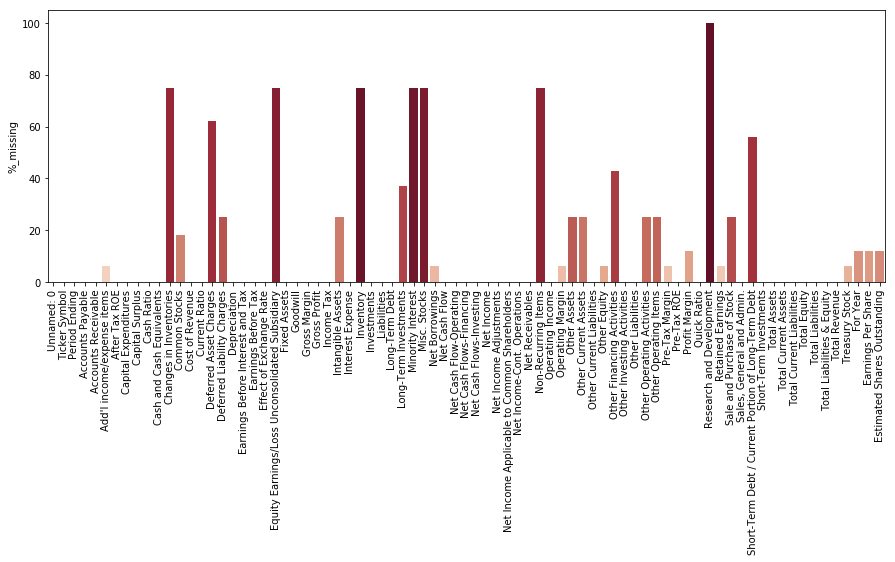

In [214]:
SubSectorData = pd.DataFrame(columns=Fundamentals.columns)
for sec in SecInSubSector['Ticker symbol']:
    SubSectorData = pd.concat([ SubSectorData, Fundamentals[Fundamentals['Ticker Symbol']==sec] ])

Threshold = 10;
Missing = pd.DataFrame(index=['type', 'num_missing', '%_missing'])
L  = len(SubSectorData)
for i,c in enumerate(SubSectorData.columns):
    if SubSectorData[c].dtypes == 'float64':
        n = len(SubSectorData[SubSectorData[c]==0]) + len(SubSectorData[SubSectorData[c].isna()])
        t = 'numeric'
    else:
        n = len(SubSectorData[SubSectorData[c].isnull()]) + len(SubSectorData[SubSectorData[c].isna()])
        t = 'text'
    
    p = int(n/L*100)
    Missing.insert(loc=len(Missing.columns), column=c, value=[t, n, p])
        
        
fig,axn = plt.subplots(figsize=(15,5)) 
pal = sns.color_palette("RdBu", len(Missing.columns))
Vals = Missing.loc['%_missing']
rank = Vals.argsort().argsort()
g = sns.barplot(ax=axn, x=Missing.columns, y=Vals, palette=np.array(pal[::-1])[rank])
g.set_xticklabels(labels=Missing.columns, rotation=90);

ColsToDrop = Missing.columns[Missing.loc['%_missing']>Threshold]

print('Dropping the following ' + str(len(ColsToDrop)) + ' columns in SubSectorData:\n')
for row in set(ColsToDrop): print(row)
#Missing = Missing.drop(columns=ColsToDrop)
SubSectorData = SubSectorData.drop(columns=ColsToDrop)

Note that things do get a little bit better when we isolate tech companies. With a 10% threshold we drop:
- 31 columns from all data
- 26 columns from sector data
- 23 columns from sub-sector data

Notice though the the sub-sector is an extremely small subset of all data made of only 4 securities! This will make it very hard to produce reliable estimates on it's properties. 

Let's save our clean datasets for later use

In [217]:
pk.dump(AllData, open('pickles/AllData.pickle', 'wb'))
pk.dump(SectorData, open('pickles/SectorData.pickle', 'wb'))
pk.dump(SubSectorData, open('pickles/SubSectorData.pickle', 'wb'))
pk.dump(Securities, open('pickles/Securities.pickle', 'wb'))
pk.dump(SecInSector, open('pickles/SecInSector.pickle', 'wb'))
pk.dump(SecInSubSector, open('pickles/SecInSubSector.pickle', 'wb'))

# Linear Regression

## Correlation Analysis

In [9]:
# load clean datasets
AllData = pk.load(open('pickles/AllData.pickle', 'rb'))
SectorData = pk.load(open('pickles/SectorData.pickle', 'rb'))
SubSectorData = pk.load(open('pickles/SubSectorData.pickle', 'rb'))
Securities = pk.load(open('pickles/Securities.pickle', 'rb'))
SecInSector = pk.load(open('pickles/SecInSector.pickle', 'rb'))
SecInSubSector = pk.load(open('pickles/SecInSubSector.pickle', 'rb'))

In the linear approximation the target variable is the 'Total Revenue' at year N and the predictors are to be evaluated at year N-1. We first attempt this approach in the three sets isolated above (all available data, sector data and subsector data) and exhamine statistical relevance. 

Given the small size of datasets, isolating the most statistically relevant set of predictors can be achieved with a simple wrapper (recursive elimination of the worst predictor until the statistics converges or becomes worse). Though it's useful to compute correlations first, especially given the large number of potential predictors.

In order to do this we need to reshape our dataset. In principle we don't know if yearly observations are consecutive or even sorted. So we add the column 'Target' that contains the variable we want to describe (revenues one year ahead)

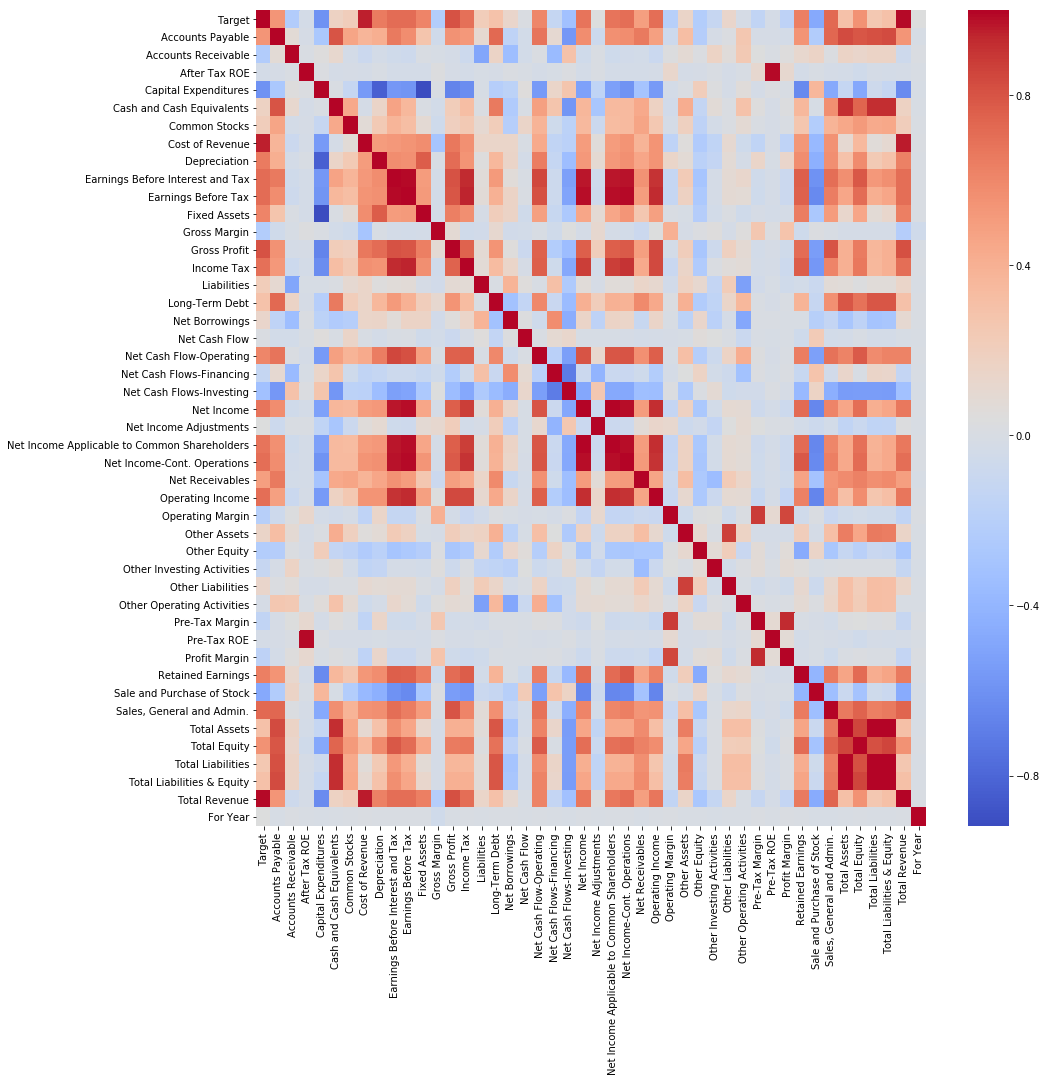

In [10]:
colNames = list(AllData.columns)
colNames.insert(len(colNames), 'Target')
Table1 = pd.DataFrame(columns=colNames)
for sec in Securities['Ticker symbol']:
    this = AllData[AllData['Ticker Symbol']==sec]
    Y = this['Period Ending'].map(lambda x:  datetime.datetime.strptime(x, '%Y-%m-%d').date().year)
    target = []
    for i,y in enumerate(Y):
        if not this[Y==y+1].empty:
            #target = pd.concat([target, this[this['Observation Year']==2016]['Total Revenue']])
            target.insert(i,this.loc[Y==y+1]['Total Revenue'].iloc[0])
        else:
            target.insert(i, np.nan)
    
    this.insert(len(this.index),'Target',np.asarray(target))
    Table1 = pd.concat([Table1, this])
    #AllData[AllData['Ticker Symbol']==sec]['Total Revenue'] = target
    
    

# order columns so to have 'Target' as first
# and compute pairwise correlations
colNames = list(AllData.columns)
colNames.insert(0, 'Target')
Table1 = Table1[colNames] 
Correlation1 = Table1.corr()
fig,axn = plt.subplots(figsize=(15,15))
g = sns.heatmap(Correlation1, cmap='coolwarm', ax=axn)

From the heatmap representation of the correlation matrix we learn that most variableas have little to no correlation (be it positive or negative) that we could exploit in a linear model. Notice that the 'Target' variable is displaced in time by +1 year, so the relative column is sensitive to predictive power, while all other columns are sensitive to contemporaneous correlation. We also notice that many variables are highly intercorrelated, which is no surprise since we're looking at accounting entries in a balance sheet.

#### Also notice that the Target Revenue is essentially determined by the previous year revenue in this dataset.

We could repeat this analysis for the smaller Industry Sector subset, and we would find a very similar pattern of correlations. More interesting is instead to cluster items into correlation groups, after purging from the most obviously uncorrelated ones.

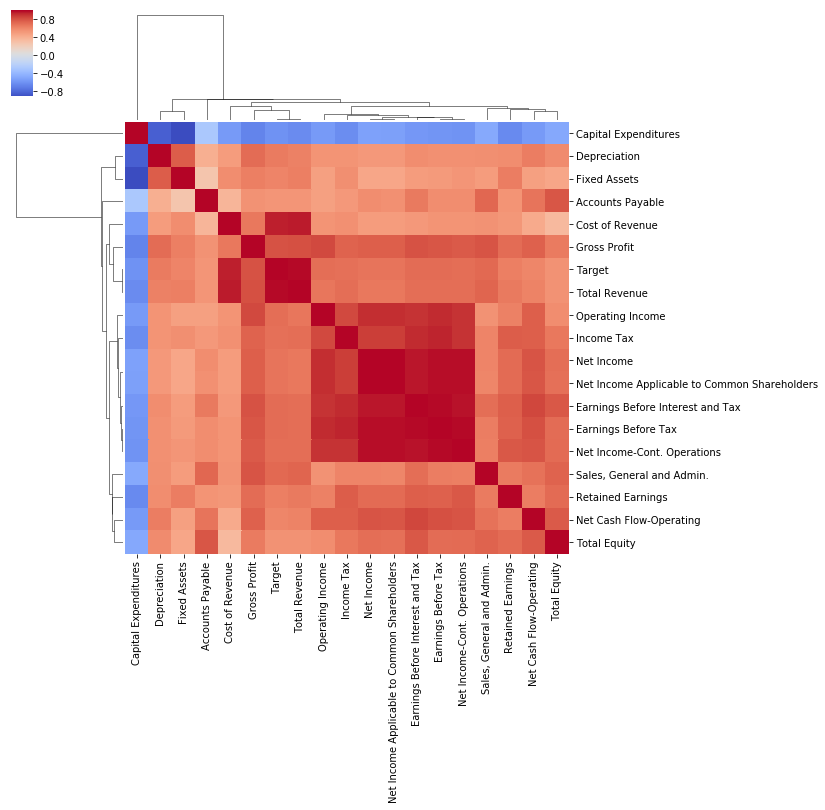

In [216]:
# Cluster analysis

colNames = list(SectorData.columns)
colNames.insert(len(colNames), 'Target')
Table2 = pd.DataFrame(columns=colNames)
for sec in Securities['Ticker symbol']:
    this = AllData[AllData['Ticker Symbol']==sec]
    Y = this['Period Ending'].map(lambda x:  datetime.datetime.strptime(x, '%Y-%m-%d').date().year)
    target = []
    for i,y in enumerate(Y):
        if not this[Y==y+1].empty:
            #target = pd.concat([target, this[this['Observation Year']==2016]['Total Revenue']])
            target.insert(i,this.loc[Y==y+1]['Total Revenue'].iloc[0])
        else:
            target.insert(i, np.nan)
    
    this.insert(len(this.index),'Target',np.asarray(target))
    Table2 = pd.concat([Table2, this])
    #SectorData[SectorData['Ticker Symbol']==sec]['Total Revenue'] = target
    
    

# order columns so to have 'Target' as first
# and compute pairwise correlations
colNames = list(SectorData.columns)
colNames.insert(0, 'Target')
Table2 = Table2[colNames] 
Correlation2 = Table2.corr()

# thresholded correlation matrix
C2 = Correlation2[Correlation2.loc[:]['Target'].abs()>0.5]
C2 = C2.transpose()
C2 = C2[C2['Target'].abs()>.5]
g = sns.clustermap(C2, cmap='coolwarm')

From the simple analysis above we learn that the target year revenue is essentially determined by the current year profit, revenue and investments made in increasing revenues (cost of revenues). We also notice the presence of a central cluster of tax-related variables, such as the Net Income, the EBIT etc. This fact is strongly in support of intuition. However we bare in mind that synchonous correlation doesn't imply any predictive capabilities about the EBIT or EPS.

Moreover this leads naturally to consider a rather important fact. Revenue-EBIT syncronous correlation is not particularly significant (although it is not poor, of course), which, in light of the results that follow, gives us a hint of how more difficult predicting the latter is w.r.t. predicting the former. Indeed, consensus analysis missing EBIT forecasts by order of magnitudes at times, highlights the involvedness of the problem. 



## Principal Component Analysis

The presence of neat correlation clusters implies that the effective number of degrees of freedom of the system is much lower than what is depicted above, even after thresholding-out about half of the candidate explicative variables. PCA can help us reduce the number of spurious predictors even further. 

We proceed as follows:
- select variables with the highest target correlation and standardize them
- apply Singular Value Decomposition with N components
- plot the ratio of explained variace as a function of N
- choose the optimal ROC positioning
- check statistical relevance of the model
- eventually apply adjustments

Note that the in the specific case at hand, a minimum knowledge of corporate accounting and the results above would allow us to carry out the dimensionality reduction "by hand" and possibly obtain a very similar result. My genuine guess is to keep 'Capital Expenditure', 'Total Revenue'  and EBIT as predictors, we can check this guess later. The purpose of the following is to show a more proper way to do things.

Also, given sizes and time span narrowness of our samples, we follow the 'less is more' approach to avoid overfitting. 

In [217]:
# choose predictors from above
C2.columns

Index(['Target', 'Accounts Payable', 'Capital Expenditures', 'Cost of Revenue',
       'Depreciation', 'Earnings Before Interest and Tax',
       'Earnings Before Tax', 'Fixed Assets', 'Gross Profit', 'Income Tax',
       'Net Cash Flow-Operating', 'Net Income',
       'Net Income Applicable to Common Shareholders',
       'Net Income-Cont. Operations', 'Operating Income', 'Retained Earnings',
       'Sales, General and Admin.', 'Total Equity', 'Total Revenue'],
      dtype='object')

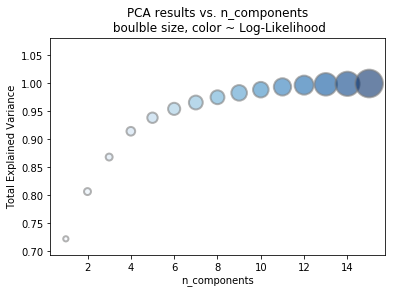

In [295]:
predictors = ['Accounts Payable', 'Capital Expenditures', 'Cost of Revenue',
       'Depreciation', 'Earnings Before Interest and Tax',
       'Earnings Before Tax', 'Fixed Assets', 'Gross Profit', 'Income Tax',
       'Net Cash Flow-Operating', 'Net Income',
       'Net Income Applicable to Common Shareholders',
       'Net Income-Cont. Operations', 'Operating Income', 'Retained Earnings',
       'Sales, General and Admin.', 'Total Equity', 'Total Revenue']

# remember we added NaN's in 'Target' field for year 2017
NaNs = Table2['Target'].isna()
target_year_ind = Table2[NaNs].index
sample_years_ind = Table2[~NaNs].index
#X = Table2.loc[:,predictors].values
#X = StandardScaler().fit_transform(X)
#X_train = X[sample_years_ind]
#X_prediction = X[target_year_ind]
Y_train = Table2.loc[sample_years_ind,'Target'].values
X_train = Table2.loc[sample_years_ind,predictors].values
X_prediction = Table2.loc[target_year_ind,predictors].values
# standardize predictors
X_train = StandardScaler().fit_transform(X_train)
X_prediction = StandardScaler().fit_transform(X_prediction)
# declaring PCA using MLE estimate of independent components
PCA_results = pd.DataFrame(columns=['Number of Components','Total Explained Variance', 'Average Log-Likelihood'])
for nc in range(15):
    pca = PCA(n_components = nc+1)
    pca.fit(X_train)
    expvar = pca.explained_variance_ratio_.sum()
    ll = pca.score(X_train)
    PCA_results.loc[nc,:] = [nc+1, expvar, ll]

# plot
size = PCA_results['Average Log-Likelihood'].values.astype(int)
size = np.flip(3*size*size, axis=0);
plt.scatter(PCA_results['Number of Components'], PCA_results['Total Explained Variance'],\
            c=PCA_results['Number of Components'],s=size,\
            cmap="Blues", alpha=0.6, edgecolors="grey", linewidth=2)
plt.xlabel('n_components')
plt.ylabel('Total Explained Variance')
plt.title('PCA results vs. n_components\n boulble size, color ~ Log-Likelihood');



Above we depicted the total explained sample variance as a function of the number of PCA components. Boubles size and colour are linearly proportional to the log likelihood of the sample given the model. Results are also reported below in table format. We see that 6 components already explain about 95% of the total variance and the improvement from adding more components becomes sluggish. This will be our tentative-optimal pick.

In [276]:
PCA_results

,Number of Components,Total Explained Variance,Average Log-Likelihood
0,1,0.722297,-16.4191
1,2,0.806702,-14.8266
2,3,0.868354,-13.2447
3,4,0.914403,-11.5433
4,5,0.938596,-10.5535
5,6,0.954452,-9.84701
6,7,0.965774,-9.30025
7,8,0.975194,-8.72124
8,9,0.983021,-8.06379
9,10,0.988694,-7.45882


## Linear Regression


Considering the results above, we isolate 6 predicotors and apply a standard linear regression algorithm with least squares optimization function. We use cross-validated prediction to estimate the model's accuracy, being the n-folds chosen as such as to maximise the error estimate, as a basic overfitting counter-maneuver. Then we generate predictions for the target sample, highlighting the one of our main interest in red.

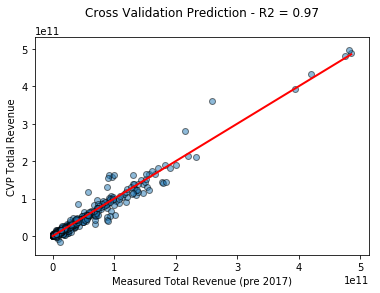

In [296]:
pca = PCA(n_components = 6)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_prediction = pca.transform(X_prediction)
# fit
LR = linear_model.LinearRegression()
LR.fit(X_train, Y_train)
# cross validate
CVP = cross_val_predict(LR, X_train, Y_train, cv=3)
rmse = np.sqrt(mean_squared_error(CVP, Y_train))
R2 = r2_score(CVP, Y_train)
# plot cross validation results
fig, ax = plt.subplots()
ax.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r', lw=2)
ax.scatter(Y_train, CVP, edgecolors='k', alpha=0.5)
ax.set_xlabel('Measured Total Revenue (pre 2017)')
ax.set_ylabel('CVP Totlal Revenue')
ax.set_title('Cross Validation Prediction - R2 = ' + str(np.round(R2,2)) + '\n')
plt.show()



We can also get some more information about the statistical relevance of the model applied.

In [301]:
MSE = (sum((Y_train-CVP)**2))/(X_train.shape[0]-X_train.shape[1])
rmse = np.sqrt(MSE)
var = MSE*(np.linalg.inv(np.dot(X_train.T,X_train)).diagonal())
sd = np.sqrt(var)
ts = LR.coef_ / sd

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X_train)-1))) for i in ts]

sd = np.round(sd,2)
ts = np.round(ts,2)
p_values = np.round(p_values,2)
params = np.round(LR.coef_,2)

Stats_df = pd.DataFrame()
Stats_df["Coefficients"],Stats_df["Standard Errors"],Stats_df["Student's t"],Stats_df["P > | t |"] = \
    [params, sd, ts, p_values]
Stats_df

,Coefficients,Standard Errors,Student's t,P > | t |
0,9.297049e+09,5.979431e+07,155.48,0.0
1,-8.213212e+09,1.749175e+08,-46.95,0.0
2,-9.072825e+09,2.046646e+08,-44.33,0.0
3,1.913243e+10,2.368152e+08,80.79,0.0
4,-4.069268e+09,3.267143e+08,-12.46,0.0
5,6.048681e+09,4.035703e+08,14.99,0.0


Finally, let's generate a prediction. The predicted Total Revenue for 2017 for Amazon in highlighted in red. 1 and 2-sigma bounds are also depicted. For comparison we add the observed value of $177.87 billions. It would be interesting to compare our result with a consensus estimate dating back to Q4 2016, but I can't find historical data. 

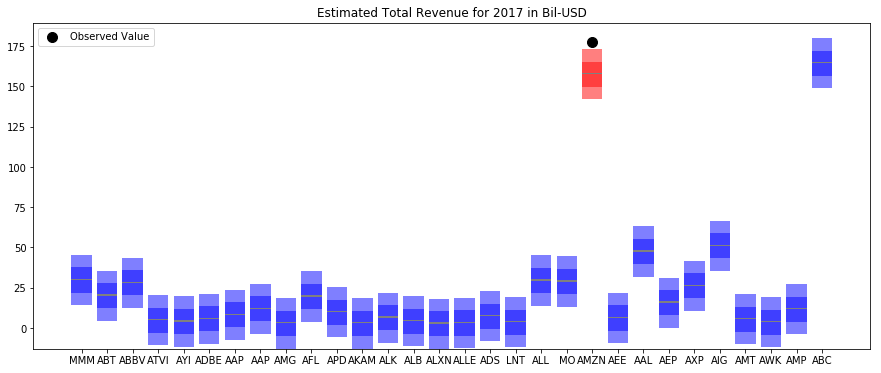

In [285]:
# predict on target
Prediction = LR.predict(X_prediction)
Pred_df = pd.DataFrame(Table2.loc[target_year_ind,'Ticker Symbol'])
Pred_df.insert(1,'Predicted Revenue',Prediction)

# plot prediction
N = 30
x = np.array([i for i in range(N)])
y = Pred_df['Predicted Revenue'].values/(10**9)
bound = rmse/10**9
y = y[:N]
lab = Pred_df['Ticker Symbol'].values
lab = lab[:N]
col = ['b']*N
AMZN = np.where(lab=='AMZN')[0][0]
Observed2017 = 177.87
col[AMZN] = 'r'
fig,axn = plt.subplots(figsize=(15,6))
plt.scatter(AMZN, Observed2017,s=100, color='k')
plt.bar(x, 4*bound, 0.8, y-2*bound, tick_label = lab, alpha=.5, color=col)
plt.bar(x, 2*bound, 0.8, y-bound, tick_label = lab, alpha=.5, color=col)
plt.bar(x, .8, 0.8, y, color='grey')
plt.title('Estimated Total Revenue for 2017 in Bil-USD')
plt.legend(['Observed Value'])
plt.show()

The prediction falls short of the 2-sigma bound, which is very intereste given that we use all data for this model, from all industry sectors! Moreover it's a year-to-year prediction based on a linear model. On the other hand it must be said that this task is relatively easy compared to the more relevant prediction of the Earnings Per Share or the EBIT (relevant for trading purposes). 

## Linear Model - Industry Sector

We repeat not the relevat steps above with a focus on Amazon own industry sector.

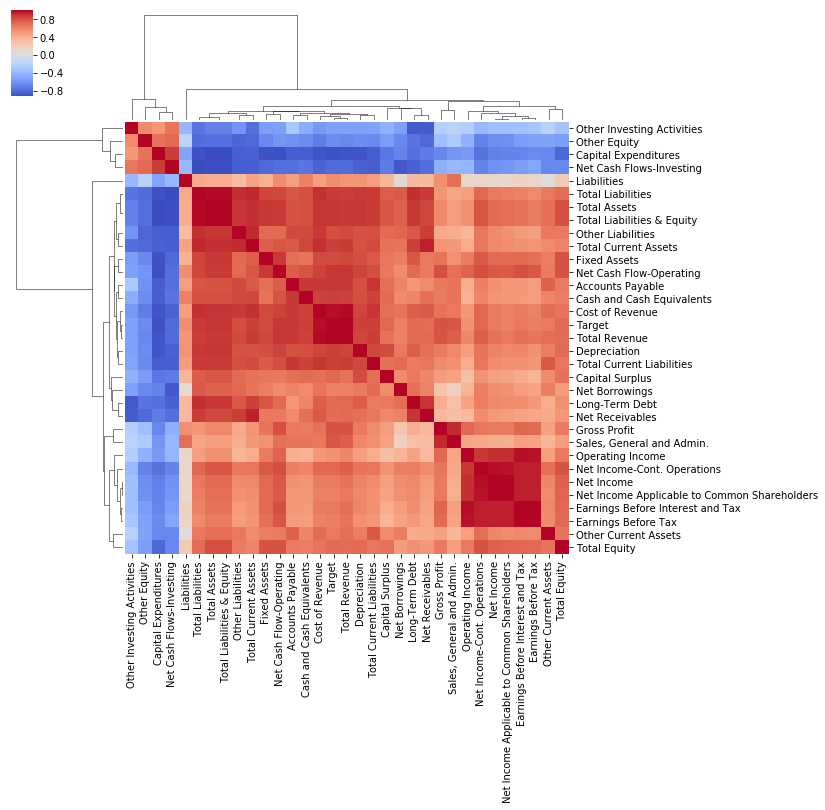

In [224]:
colNames = list(SectorData.columns)
colNames.insert(len(colNames), 'Target')
Table3 = pd.DataFrame(columns=colNames)
for sec in SecInSector['Ticker symbol']:
    this = SectorData[SectorData['Ticker Symbol']==sec]
    Y = this['Period Ending'].map(lambda x:  datetime.datetime.strptime(x, '%Y-%m-%d').date().year)
    target = []
    for i,y in enumerate(Y):
        if not this[Y==y+1].empty:
            #target = pd.concat([target, this[this['Observation Year']==2016]['Total Revenue']])
            target.insert(i,this.loc[Y==y+1]['Total Revenue'].iloc[0])
        else:
            target.insert(i, np.nan)
    
    this.insert(len(this.index),'Target',np.asarray(target))
    Table3 = pd.concat([Table3, this])
    #SectorData[SectorData['Ticker Symbol']==sec]['Total Revenue'] = target
    
    

# order columns so to have 'Target' as first
# and compute pairwise correlations
colNames = list(SectorData.columns)
colNames.insert(0, 'Target')
Table3 = Table3[colNames] 
Correlation3 = Table3.corr()

# thresholded correlation matrix
C3 = Correlation3[Correlation3.loc[:]['Target'].abs()>0.5]
C3 = C3.transpose()
C3 = C3[C3['Target'].abs()>.5]
g = sns.clustermap(C3, cmap='coolwarm')

We already see a big difference in the number of predictors having a large and negative correlation.

In [226]:
C3.columns

Index(['Target', 'Accounts Payable', 'Capital Expenditures', 'Capital Surplus',
       'Cash and Cash Equivalents', 'Cost of Revenue', 'Depreciation',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Fixed Assets', 'Gross Profit', 'Liabilities', 'Long-Term Debt',
       'Net Borrowings', 'Net Cash Flow-Operating', 'Net Cash Flows-Investing',
       'Net Income', 'Net Income Applicable to Common Shareholders',
       'Net Income-Cont. Operations', 'Net Receivables', 'Operating Income',
       'Other Current Assets', 'Other Equity', 'Other Investing Activities',
       'Other Liabilities', 'Sales, General and Admin.', 'Total Assets',
       'Total Current Assets', 'Total Current Liabilities', 'Total Equity',
       'Total Liabilities', 'Total Liabilities & Equity', 'Total Revenue'],
      dtype='object')

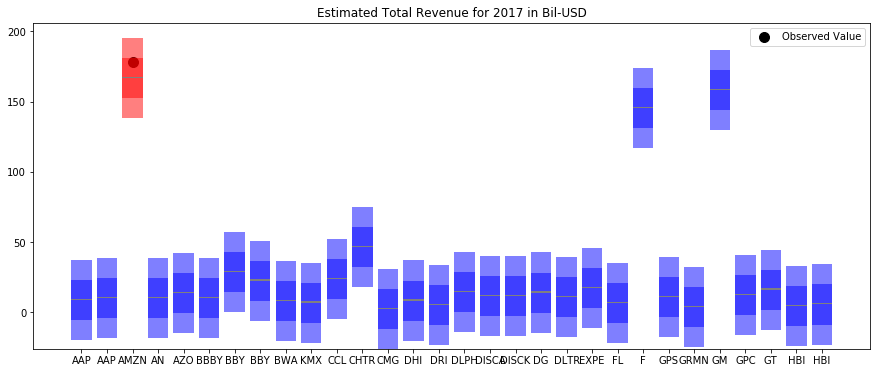

In [287]:
predictors = ['Accounts Payable', 'Capital Expenditures', 'Capital Surplus',\
       'Cash and Cash Equivalents', 'Cost of Revenue', 'Depreciation',\
       'Earnings Before Interest and Tax', 'Earnings Before Tax',\
       'Fixed Assets', 'Gross Profit', 'Liabilities', 'Long-Term Debt',\
       'Net Borrowings', 'Net Cash Flow-Operating', 'Net Cash Flows-Investing',\
       'Net Income', 'Net Income Applicable to Common Shareholders',\
       'Net Income-Cont. Operations', 'Net Receivables', 'Operating Income',\
       'Other Current Assets', 'Other Equity', 'Other Investing Activities',\
       'Other Liabilities', 'Sales, General and Admin.', 'Total Assets',\
       'Total Current Assets', 'Total Current Liabilities', 'Total Equity',\
       'Total Liabilities', 'Total Liabilities & Equity', 'Total Revenue']

# remember we added NaN's in 'Target' field for year 2017
NaNs = Table3['Target'].isna()
target_year_ind = Table3[NaNs].index
sample_years_ind = Table3[~NaNs].index
#X = Table2.loc[:,predictors].values
#X = StandardScaler().fit_transform(X)
#X_train = X[sample_years_ind]
#X_prediction = X[target_year_ind]
Y_train = Table3.loc[sample_years_ind,'Target'].values
X_train = Table3.loc[sample_years_ind,predictors].values
X_prediction = Table3.loc[target_year_ind,predictors].values
# standardize predictors
X_train = StandardScaler().fit_transform(X_train)
X_prediction = StandardScaler().fit_transform(X_prediction)
pca = PCA(n_components = 6)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_prediction = pca.transform(X_prediction)
# fit
LR = linear_model.LinearRegression()
LR.fit(X_train, Y_train)
# cross validate
CVP = cross_val_predict(LR, X_train, Y_train, cv=6)
rmse = np.sqrt(mean_squared_error(CVP, Y_train))
R2 = r2_score(CVP, Y_train)

# predict on target
Prediction = LR.predict(X_prediction)
Pred_df = pd.DataFrame(Table3.loc[target_year_ind,'Ticker Symbol'])
Pred_df.insert(1,'Predicted Revenue',Prediction)
# plot prediction
N = 30
x = np.array([i for i in range(N)])
y = Pred_df['Predicted Revenue'].values/(10**9)
bound = rmse/10**9
y = y[:N]
lab = Pred_df['Ticker Symbol'].values
lab = lab[:N]
col = ['b']*N
AMZN = np.where(lab=='AMZN')[0][0]
Observed2017 = 177.87
col[AMZN] = 'r'
fig,axn = plt.subplots(figsize=(15,6))
plt.scatter(AMZN, Observed2017,s=100, color='k')
plt.bar(x, 4*bound, 0.8, y-2*bound, tick_label = lab, alpha=.5, color=col)
plt.bar(x, 2*bound, 0.8, y-bound, tick_label = lab, alpha=.5, color=col)
plt.bar(x, .8, 0.8, y, color='grey')
plt.title('Estimated Total Revenue for 2017 in Bil-USD')
plt.legend(['Observed Value'])
plt.show()

In [288]:
MSE = (sum((Y_train-CVP)**2))/(X_train.shape[0]-X_train.shape[1])
rmse = np.sqrt(MSE)
var = MSE*(np.linalg.inv(np.dot(X_train.T,X_train)).diagonal())
sd = np.sqrt(var)
ts = LR.coef_ / sd

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X_train)-1))) for i in ts]

sd = np.round(sd,2)
ts = np.round(ts,2)
p_values = np.round(p_values,2)
params = np.round(LR.coef_,2)

Stats_df = pd.DataFrame()
Stats_df["Coefficients"],Stats_df["Standard Errors"],Stats_df["Student's t"],Stats_df["P > | t |"] = \
    [params, sd, ts, p_values]
Stats_df

,Coefficients,Standard Errors,Student's t,P > | t |
0,5.782962e+09,2.049117e+08,28.22,0.00
1,7.368082e+08,5.158540e+08,1.43,0.15
2,4.991018e+09,6.460224e+08,7.73,0.00
3,-1.761425e+09,7.860807e+08,-2.24,0.03
4,1.642788e+09,1.232690e+09,1.33,0.18
5,-1.860450e+09,1.372801e+09,-1.36,0.18


A visible improvement in the prediction but at the cose of a worse statistical relevance of some of some predictors.

## Linear Model - Only Sub-Sector

The size of the industry-sub-sector dataset is quite small, consisting of only 4 corporates with an average of 4 samples per corporate. Nonetheless restrincting the model to companies that are very likely to share many patterns, might be interesting. 

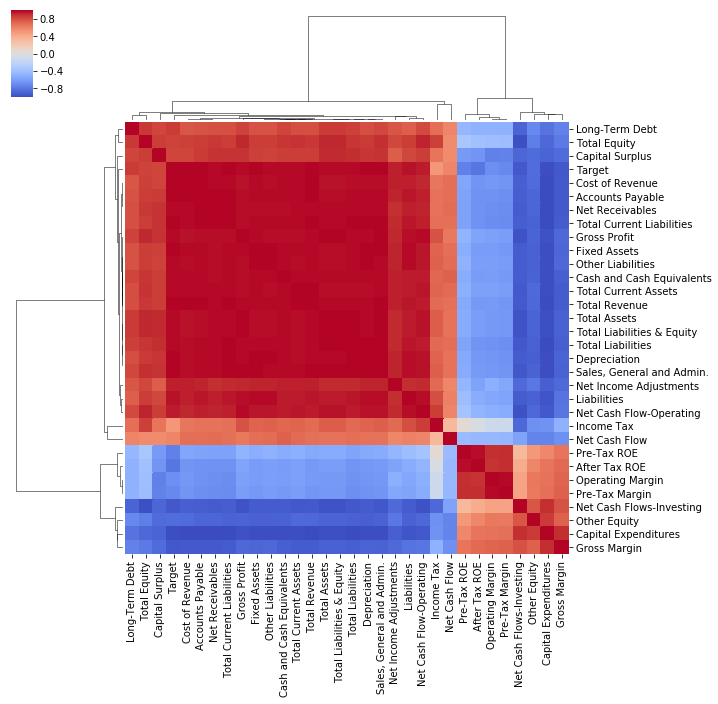

In [235]:
colNames = list(SectorData.columns)
colNames.insert(len(colNames), 'Target')
Table4 = pd.DataFrame(columns=colNames)
for sec in SecInSubSector['Ticker symbol']:
    this = SubSectorData[SubSectorData['Ticker Symbol']==sec]
    Y = this['Period Ending'].map(lambda x:  datetime.datetime.strptime(x, '%Y-%m-%d').date().year)
    target = []
    for i,y in enumerate(Y):
        if not this[Y==y+1].empty:
            #target = pd.concat([target, this[this['Observation Year']==2016]['Total Revenue']])
            target.insert(i,this.loc[Y==y+1]['Total Revenue'].iloc[0])
        else:
            target.insert(i, np.nan)
    
    this.insert(len(this.index),'Target',np.asarray(target))
    Table4 = pd.concat([Table4, this])
    #SectorData[SectorData['Ticker Symbol']==sec]['Total Revenue'] = target
    
    

# order columns so to have 'Target' as first
# and compute pairwise correlations
colNames = list(SectorData.columns)
colNames.insert(0, 'Target')
Table4 = Table4[colNames] 
Correlation4 = Table4.corr()

# thresholded correlation matrix
C4 = Correlation4[Correlation4.loc[:]['Target'].abs()>0.5]
C4 = C4.transpose()
C4 = C4[C4['Target'].abs()>.5]
g = sns.clustermap(C4, cmap='coolwarm')

Notice that the anti-correlation pattern between accounting items and financial items becomes more evident when we move towards tech companies. This might be a manifestation of the broad finantial activities that many corporates pursue in order to minimize tax pressure on revenues (like reinvesting in fixed income).

In [236]:
C4.columns

Index(['Target', 'Accounts Payable', 'After Tax ROE', 'Capital Expenditures',
       'Capital Surplus', 'Cash and Cash Equivalents', 'Cost of Revenue',
       'Depreciation', 'Fixed Assets', 'Gross Margin', 'Gross Profit',
       'Income Tax', 'Liabilities', 'Long-Term Debt', 'Net Cash Flow',
       'Net Cash Flow-Operating', 'Net Cash Flows-Investing',
       'Net Income Adjustments', 'Net Receivables', 'Operating Margin',
       'Other Equity', 'Other Liabilities', 'Pre-Tax Margin', 'Pre-Tax ROE',
       'Sales, General and Admin.', 'Total Assets', 'Total Current Assets',
       'Total Current Liabilities', 'Total Equity', 'Total Liabilities',
       'Total Liabilities & Equity', 'Total Revenue'],
      dtype='object')

In [245]:
predictors = ['Accounts Payable', 'After Tax ROE', 'Capital Expenditures',\
       'Capital Surplus', 'Cash and Cash Equivalents', 'Cost of Revenue',\
       'Depreciation', 'Fixed Assets', 'Gross Margin', 'Gross Profit',\
       'Income Tax', 'Liabilities', 'Long-Term Debt', 'Net Cash Flow',\
       'Net Cash Flow-Operating', 'Net Cash Flows-Investing',\
       'Net Income Adjustments', 'Net Receivables', 'Operating Margin',\
       'Other Equity', 'Other Liabilities', 'Pre-Tax Margin', 'Pre-Tax ROE',\
       'Sales, General and Admin.', 'Total Assets', 'Total Current Assets',\
       'Total Current Liabilities', 'Total Equity', 'Total Liabilities',\
       'Total Liabilities & Equity', 'Total Revenue']

# remember we added NaN's in 'Target' field for year 2017
NaNs = Table4['Target'].isna()
target_year_ind = Table4[NaNs].index
sample_years_ind = Table4[~NaNs].index
#X = Table2.loc[:,predictors].values
#X = StandardScaler().fit_transform(X)
#X_train = X[sample_years_ind]
#X_prediction = X[target_year_ind]
Y_train = Table4.loc[sample_years_ind,'Target'].values
X_train = Table4.loc[sample_years_ind,predictors].values
X_prediction = Table4.loc[target_year_ind,predictors].values
# standardize predictors
X_train = StandardScaler().fit_transform(X_train)
X_prediction = StandardScaler().fit_transform(X_prediction)

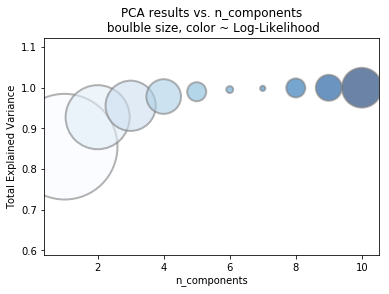

In [252]:
# declaring PCA 
PCA_results = pd.DataFrame(columns=['Number of Components','Total Explained Variance', 'Average Log-Likelihood'])
for nc in range(10):
    pca = PCA(n_components = nc+1)
    pca.fit(X_train)
    expvar = pca.explained_variance_ratio_.sum()
    ll = pca.score(X_train)
    PCA_results.loc[nc,:] = [nc+1, expvar, ll]

# plot
size = PCA_results['Average Log-Likelihood'].values.astype(int)
size = np.flip(3*size*size, axis=0);
plt.scatter(PCA_results['Number of Components'], PCA_results['Total Explained Variance'],\
            c=PCA_results['Number of Components'],s=size,\
            cmap="Blues", alpha=0.6, edgecolors="grey", linewidth=2)
plt.xlabel('n_components')
plt.ylabel('Total Explained Variance')
plt.title('PCA results vs. n_components\n boulble size, color ~ Log-Likelihood');

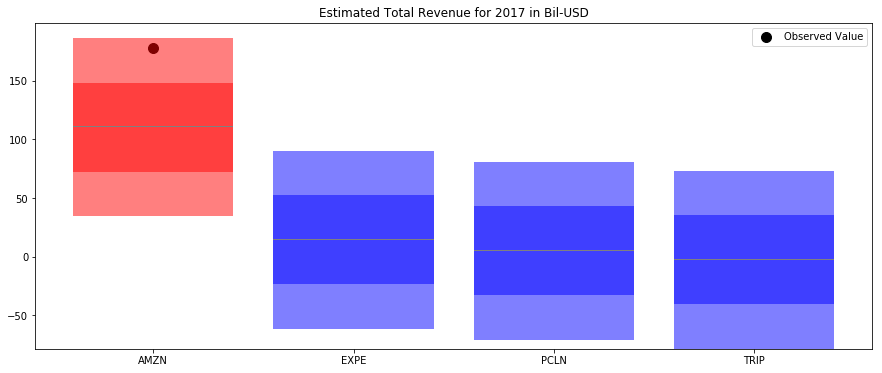

In [261]:
# fit
pca = PCA(n_components = 2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_prediction = pca.transform(X_prediction)
LR = linear_model.LinearRegression()
LR.fit(X_train, Y_train)
# cross validate
CVP = cross_val_predict(LR, X_train, Y_train, cv=5)
rmse = np.sqrt(mean_squared_error(CVP, Y_train))
R2 = r2_score(CVP, Y_train)

# predict on target
Prediction = LR.predict(X_prediction)
Pred_df = pd.DataFrame(Table4.loc[target_year_ind,'Ticker Symbol'])
Pred_df.insert(1,'Predicted Revenue',Prediction)
# plot prediction
N = 4
x = np.array([i for i in range(N)])
y = Pred_df['Predicted Revenue'].values/(10**9)
bound = rmse/10**9
y = y[:N]
lab = Pred_df['Ticker Symbol'].values
lab = lab[:N]
col = ['b']*N
AMZN = np.where(lab=='AMZN')[0][0]
Observed2017 = 177.87
col[AMZN] = 'r'
fig,axn = plt.subplots(figsize=(15,6))
plt.scatter(AMZN, Observed2017,s=100, color='k')
plt.bar(x, 4*bound, 0.8, y-2*bound, tick_label = lab, alpha=.5, color=col)
plt.bar(x, 2*bound, 0.8, y-bound, tick_label = lab, alpha=.5, color=col)
plt.bar(x, .8, 0.8, y, color='grey')
plt.title('Estimated Total Revenue for 2017 in Bil-USD')
plt.legend(['Observed Value'])
plt.show()

Notice that the observed data-point falls within the range of prediction only because the rmse is much larger in this case (the fold-number of cross validations must be recalibrated to the smaller dataset).
In this case the available data are insufficient in order to produce reliable predictions. Notice that already at the level of PCA, a large ammount of intercorrelation between predictors is recorded. This has not to be interpreted as a feature of this data sub-set, but rather as a failure of the linear model. 